# Arima using the 13 original indices

This part is using the ARIMA model from statsmodels in order to forecast the original 13 indices that were decided as important by both the graduate student advisors of this project and the collaborating scientists who conducted the experiment.

In [20]:
import pandas as pd
from scipy import stats
import numpy as np
import matplotlib.pyplot as plt

mouse_df_list = list()

# pull 16 mice PCA data
for i in range(1,17):
    df = pd.read_excel("data/originalVars/{}.xlsx".format(i))
    mouse_df_list.append(df)


# create array that will hold all graphs
graphs = []
for mouse in mouse_df_list:
    # create mouse array and iterate through 13 variables
    mouseN = []
    for i in range(13):
        dfAti = pd.DataFrame(mouse.iloc[:, i])
        dfAti.insert(0, 'DateTime', mouse['DateTime'])
        mouseN.append(dfAti)
    graphs.append(mouseN)

print(len(graphs))
print(len(mouseN))
dfAti




16
13


,DateTime,Stilltime_M
0,2022/11/04 14:01:00,15.44444
1,2022/11/04 14:31:00,0.00000
2,2022/11/04 15:01:00,26.77778
3,2022/11/04 15:31:00,19.27778
4,2022/11/04 16:01:00,8.00000
...,...,...
1136,2022/11/28 06:01:00,38.00000
1137,2022/11/28 06:31:00,86.61111
1138,2022/11/28 07:01:00,82.27778
1139,2022/11/28 07:31:00,85.72222


In [21]:
# first trying it on a singular graph before scaling
df = graphs[15][2]
df

,DateTime,VH2O_M
0,2022/11/04 14:01:00,0.201321
1,2022/11/04 14:31:00,0.218149
2,2022/11/04 15:01:00,0.208647
3,2022/11/04 15:31:00,0.199221
4,2022/11/04 16:01:00,0.191377
...,...,...
1136,2022/11/28 06:01:00,0.161747
1137,2022/11/28 06:31:00,0.160369
1138,2022/11/28 07:01:00,0.115218
1139,2022/11/28 07:31:00,0.101589


In [22]:
df['DateTime'] = pd.to_datetime(df['DateTime'])
df.set_index('DateTime',inplace=True)
df.head()

,VH2O_M
DateTime,
2022-11-04 14:01:00,0.201321
2022-11-04 14:31:00,0.218149
2022-11-04 15:01:00,0.208647
2022-11-04 15:31:00,0.199221
2022-11-04 16:01:00,0.191377


In [23]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
VH2O_M,1141.0,0.186527,0.070879,0.011611,0.129861,0.184489,0.235117,0.442022


<Axes: xlabel='DateTime'>

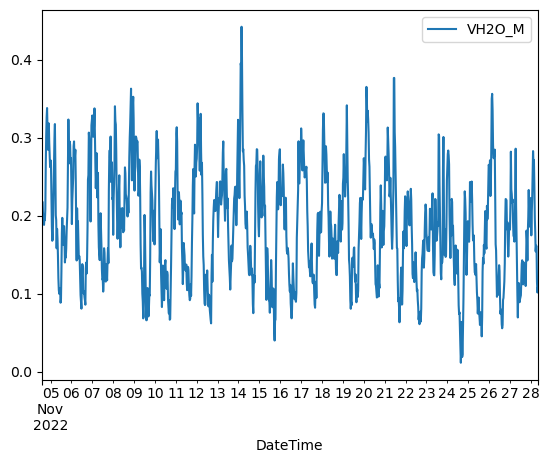

In [24]:
df.plot()

In [25]:
time_series = df.iloc[:, 0]
type(time_series)

pandas.core.series.Series

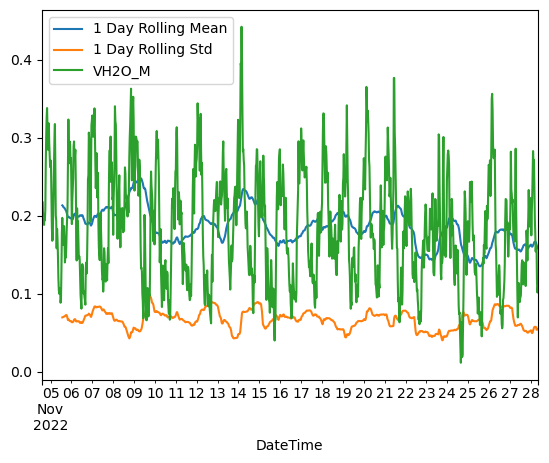

In [26]:
time_series.rolling(48).mean().plot(label='1 Day Rolling Mean')
time_series.rolling(48).std().plot(label='1 Day Rolling Std')
time_series.plot()
plt.legend()

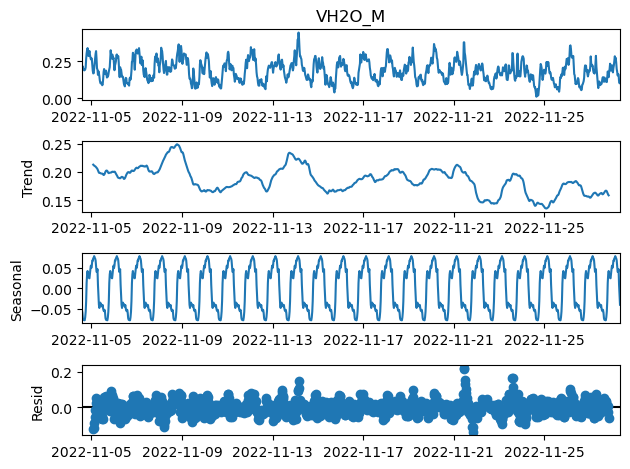

In [27]:
from statsmodels.tsa.seasonal import seasonal_decompose

decompfreq = 48
decomp = seasonal_decompose(time_series, period=decompfreq)
fig = decomp.plot()

In [28]:
# white noise inspection? maybe will do that later.

In [29]:
# stationarity inspection using augmented Dickey-Fuller(ADF) test
from statsmodels.tsa.stattools import adfuller
adfuller(df)


(-10.977424812560313,
 7.60737681917673e-20,
 21,
 1119,
 {'1%': -3.436207340777824,
  '5%': -2.8641263411190323,
  '10%': -2.5681470422493593},
 -5068.829589858256)

In [37]:
# updated stationarity test with reference to: https://www.alldatascience.com/time-series/forecasting-time-series-with-arima/
x = df.VH2O_M
result = adfuller(x)
result



(-10.977424812560313,
 7.60737681917673e-20,
 21,
 1119,
 {'1%': -3.436207340777824,
  '5%': -2.8641263411190323,
  '10%': -2.5681470422493593},
 -5068.829589858256)

<Axes: xlabel='DateTime'>

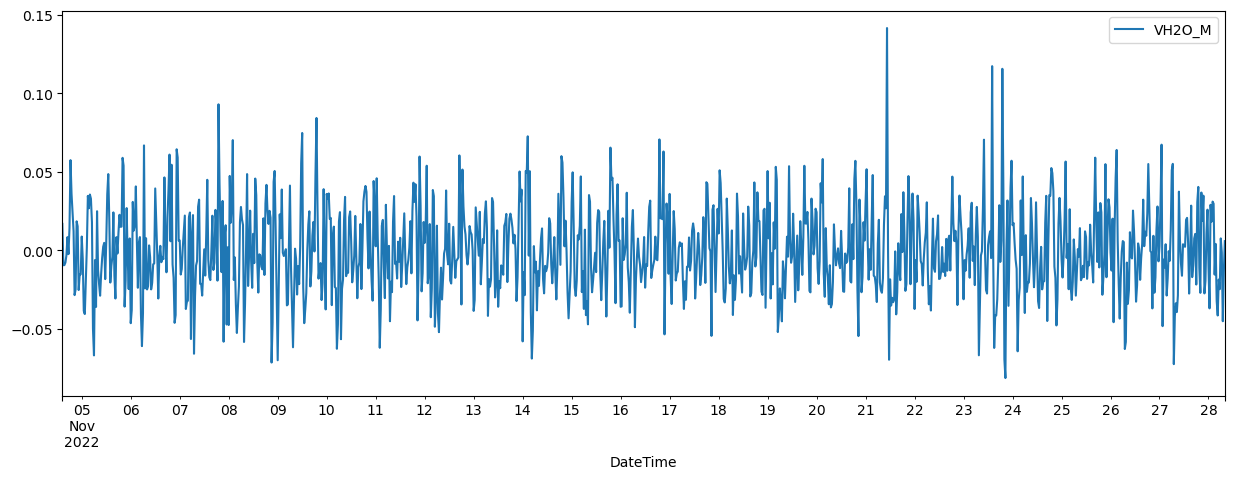

In [38]:
# does not seem to need differencing. Will still try to difference just to see the results
data_diff=df.diff().dropna()
data_diff.plot(figsize=(15,5))

In [39]:
# for some reason, after differencing, it makes it a tiny bit worse in a way. Odd... probably do not need differencing
diffx = data_diff.VH2O_M
fuller = adfuller(diffx)
fuller

(-10.312371822127213,
 3.1608833142061205e-18,
 23,
 1116,
 {'1%': -3.436223122757065,
  '5%': -2.864133302917274,
  '10%': -2.5681507500224816},
 -4987.741170410498)

## Result:
The p-value is 7.6 * 10^-20, which is significantly less than 0.05. Therefore, we can reject the null hypothesis and say that stationarity exists in the series. No differencing will be necessary, resulting in a value of d = 0

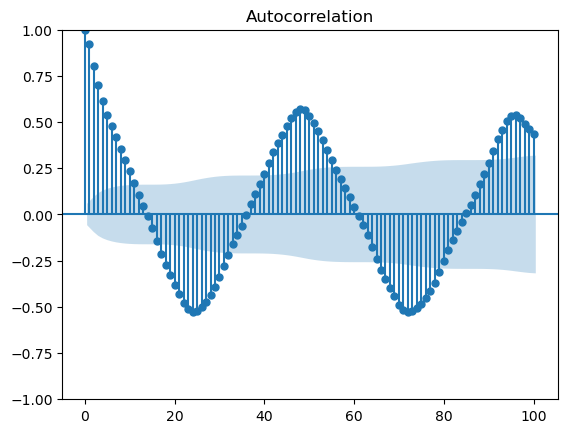

In [31]:
# ACF to determine q
from statsmodels.graphics.tsaplots import plot_acf

acf = plot_acf(df, lags=100)


# Inferences:
In this case the ACF function drops below zero. I am a bit confused on how that exactly correlates to the AR or MA values

/Users/niklaschang/anaconda3/lib/python3.10/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


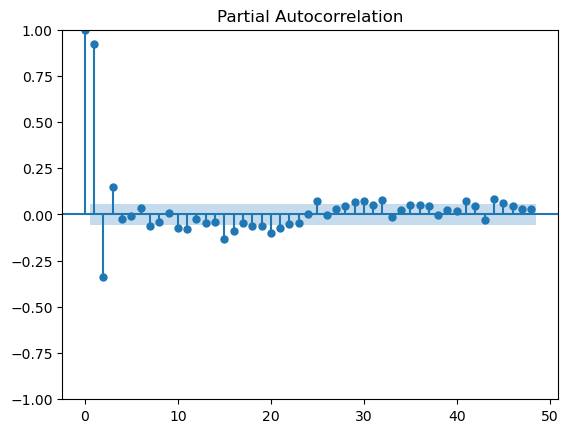

In [32]:
from statsmodels.graphics.tsaplots import plot_pacf

#pacf graph
pacf = plot_pacf(df, lags=48)

## ACF and PACF Conclusions:
Based on the paper on ARIMA modeling written by our graduate advisors, the ACF and PACF values should be around 10 and 3 respectively. Of course this is a very elementary interpretation where we pick the p and q value based on where the autocorrelation reaches the shaded area, Not including whether that value is negative or positive as seen and included from the PACF graph.

Therefore, the ARIMA model will be run with the (p,d,q) values of (10,0,3)

## Creating the ARIMA Model
Fairly simple process using code I found from https://machinelearningmastery.com/arima-for-time-series-forecasting-with-python/. However, the value of d, or the differencing, has to be put into question. based on some decomposition graphs and analysis, I see a "visible" trend in some of the plotted graphs. However, from what I know using ADF, there should not be differencing. Therefore, I will try both (10,0,3) and (10,1,3) and check the residuals to see if there is a noticeable difference. The frequency is put at 30T which stands for every 30 minutes.

/Users/niklaschang/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency 30T will be used.
  self._init_dates(dates, freq)
/Users/niklaschang/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                               SARIMAX Results                                
Dep. Variable:                 VH2O_M   No. Observations:                 1141
Model:                ARIMA(10, 0, 3)   Log Likelihood                2579.074
Date:                Thu, 06 Jul 2023   AIC                          -5128.149
Time:                        15:54:14   BIC                          -5052.554
Sample:                    11-04-2022   HQIC                         -5099.602
                         - 11-28-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1852      0.007     26.369      0.000       0.171       0.199
ar.L1          0.7840      0.422      1.858      0.063      -0.043       1.611
ar.L2          0.0165      0.588      0.028      0.9

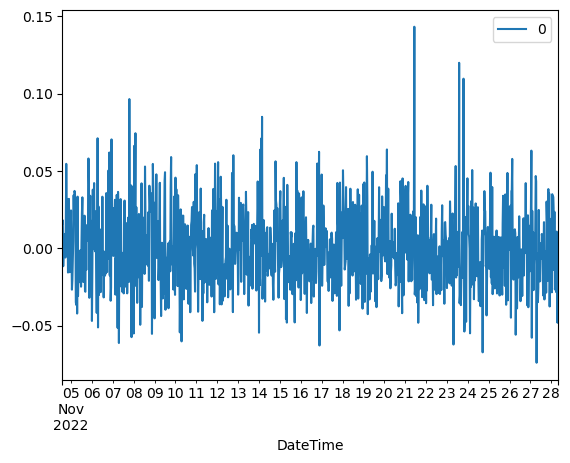

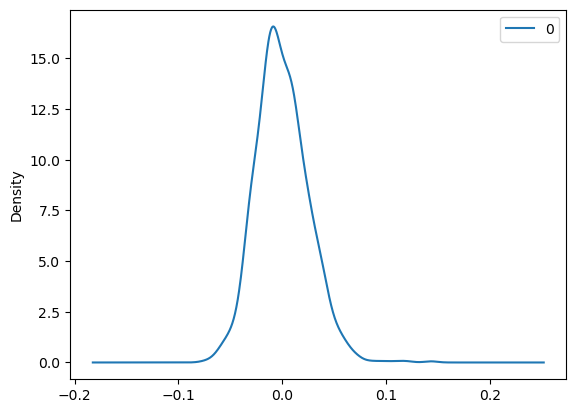

                 0
count  1141.000000
mean      0.000112
std       0.025232
min      -0.073838
25%      -0.016419
50%      -0.002491
75%       0.015145
max       0.143279


In [33]:
# fit an ARIMA model and plot residual errors

from statsmodels.tsa.arima.model import ARIMA

# fit model 
model = ARIMA(df, order=(10,0,3), freq='30T')
model_fit = model.fit()
# summary of fit model
print(model_fit.summary())
# line plot of residuals
residuals = pd.DataFrame(model_fit.resid)
residuals.plot()
plt.show()
# density plot of residuals (errors)
residuals.plot(kind='kde')
plt.show()
# summary stats of residuals
print(residuals.describe())

/Users/niklaschang/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency 30T will be used.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                 VH2O_M   No. Observations:                 1141
Model:                ARIMA(10, 1, 3)   Log Likelihood                2549.430
Date:                Thu, 06 Jul 2023   AIC                          -5070.860
Time:                        15:54:15   BIC                          -5000.317
Sample:                    11-04-2022   HQIC                         -5044.220
                         - 11-28-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1589      2.175      0.073      0.942      -4.104       4.422
ar.L2         -0.0794      1.292     -0.061      0.951      -2.613       2.454
ar.L3         -0.0397      1.309     -0.030      0.9

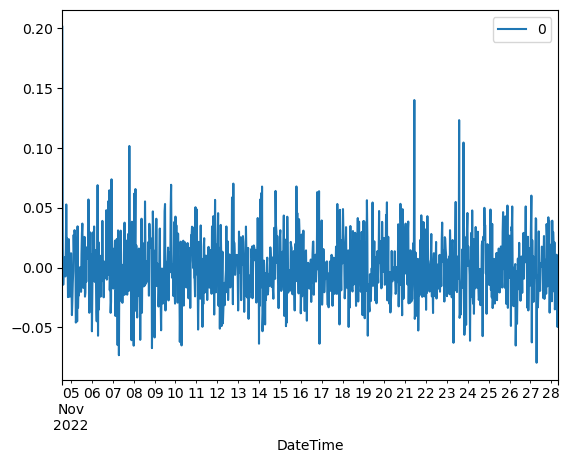

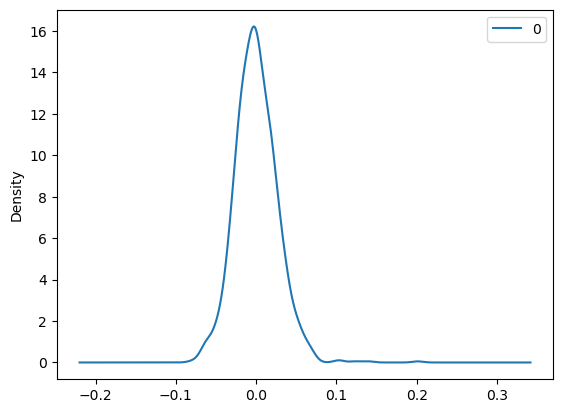

                 0
count  1141.000000
mean      0.000104
std       0.026531
min      -0.079471
25%      -0.017257
50%      -0.001149
75%       0.016458
max       0.201321


In [34]:
# fit an ARIMA model and plot residual errors

from statsmodels.tsa.arima.model import ARIMA

# fit model 
model = ARIMA(df, order=(10,1,3), freq='30T')
model_fit = model.fit()
# summary of fit model
print(model_fit.summary())
# line plot of residuals
residuals = pd.DataFrame(model_fit.resid)
residuals.plot()
plt.show()
# density plot of residuals (errors)
residuals.plot(kind='kde')
plt.show()
# summary stats of residuals
print(residuals.describe())

/Users/niklaschang/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency 30T will be used.
  self._init_dates(dates, freq)
/Users/niklaschang/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                               SARIMAX Results                                
Dep. Variable:                 VH2O_M   No. Observations:                 1141
Model:                ARIMA(10, 2, 3)   Log Likelihood                2540.360
Date:                Thu, 06 Jul 2023   AIC                          -5052.719
Time:                        15:54:18   BIC                          -4982.189
Sample:                    11-04-2022   HQIC                         -5026.083
                         - 11-28-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.7179      0.635     -1.131      0.258      -1.962       0.527
ar.L2         -0.4135      0.544     -0.759      0.448      -1.481       0.654
ar.L3         -0.1051      0.164     -0.642      0.5

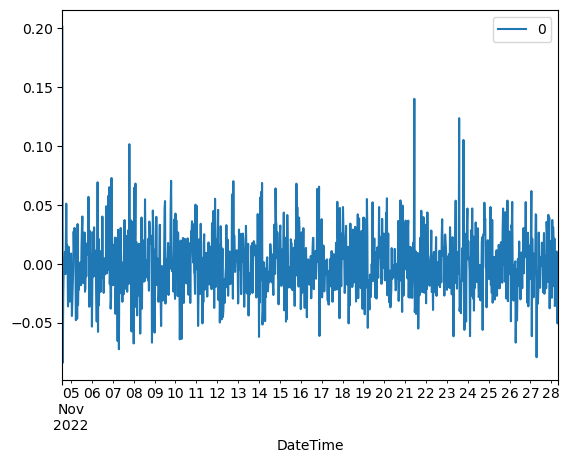

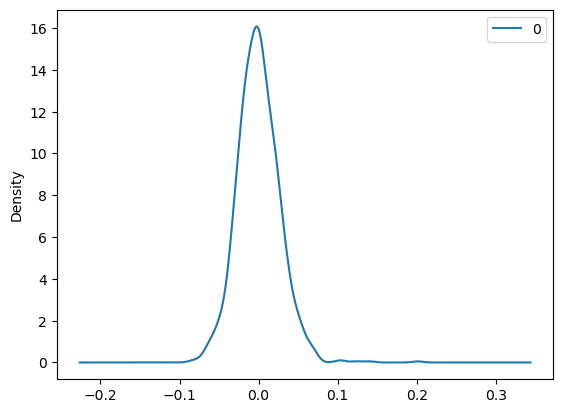

                 0
count  1141.000000
mean     -0.000075
std       0.026772
min      -0.083833
25%      -0.017485
50%      -0.001175
75%       0.016462
max       0.201321


In [35]:
# fit an ARIMA model and plot residual errors

from statsmodels.tsa.arima.model import ARIMA

# fit model 
model = ARIMA(df, order=(10,2,3), freq='30T')
model_fit = model.fit()
# summary of fit model
print(model_fit.summary())
# line plot of residuals
residuals = pd.DataFrame(model_fit.resid)
residuals.plot()
plt.show()
# density plot of residuals (errors)
residuals.plot(kind='kde')
plt.show()
# summary stats of residuals
print(residuals.describe())

## Observations:
It seems that differencing actually helps out. I wonder if I am using the ADF function wrong since it seems that accounting for a trend leads to smaller errors/residuals. A differencing of 2 was also tried since I was curious what it would do. I can't tell much a difference, it looks maybe a bit smoother.

## --Forecasting--

Onto the forecasting. This code is also just copied over and tweaked around a bit. The main thing is playing around with hyper-variables such as the test vs training datasets. Professor Wang mentioned trying out training using 22 out of the 24 days and using the last two days for testing. 

predicted=0.262307, expected=0.262565
predicted=0.259864, expected=0.226222
predicted=0.215874, expected=0.191985
predicted=0.182183, expected=0.171891
predicted=0.166126, expected=0.188410
predicted=0.193136, expected=0.189013
predicted=0.189185, expected=0.179448
predicted=0.176712, expected=0.175626
predicted=0.174532, expected=0.176852
predicted=0.177203, expected=0.168577
predicted=0.166210, expected=0.157225
predicted=0.153977, expected=0.169587
predicted=0.173121, expected=0.164837
predicted=0.163481, expected=0.138695
predicted=0.131223, expected=0.112277
predicted=0.104703, expected=0.110226
predicted=0.109638, expected=0.102119
predicted=0.099796, expected=0.095124
predicted=0.093120, expected=0.096935
predicted=0.097454, expected=0.136429
predicted=0.147748, expected=0.116850
predicted=0.111280, expected=0.096348
predicted=0.090506, expected=0.112882
predicted=0.117581, expected=0.107267
predicted=0.105673, expected=0.152568
predicted=0.165407, expected=0.209532
predicted=0.

/Users/niklaschang/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/niklaschang/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=0.214260, expected=0.189831
predicted=0.180368, expected=0.158571
predicted=0.149585, expected=0.157866
predicted=0.157663, expected=0.117086
predicted=0.105378, expected=0.090310
predicted=0.082596, expected=0.094785
predicted=0.096072, expected=0.082461
predicted=0.078918, expected=0.063449
predicted=0.057977, expected=0.086480
predicted=0.093088, expected=0.085348
predicted=0.085023, expected=0.122326
predicted=0.132923, expected=0.133520
predicted=0.136728, expected=0.107707
predicted=0.100322, expected=0.086233
predicted=0.080077, expected=0.103551
predicted=0.108502, expected=0.150790
predicted=0.164348, expected=0.179777
predicted=0.188131, expected=0.158186


/Users/niklaschang/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/niklaschang/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/niklaschang/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=0.151993, expected=0.169684
predicted=0.172975, expected=0.205823
predicted=0.216188, expected=0.224812
predicted=0.230268, expected=0.187434
predicted=0.176743, expected=0.181142
predicted=0.179344, expected=0.161091
predicted=0.155358, expected=0.195900
predicted=0.205809, expected=0.220165
predicted=0.227091, expected=0.231122
predicted=0.234251, expected=0.224301
predicted=0.222355, expected=0.215525
predicted=0.213019, expected=0.193141
predicted=0.186744, expected=0.187639
predicted=0.186067, expected=0.192699


/Users/niklaschang/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/niklaschang/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=0.194145, expected=0.203861
predicted=0.207050, expected=0.234409
predicted=0.243153, expected=0.220771
predicted=0.216882, expected=0.186403
predicted=0.176580, expected=0.163550
predicted=0.157002, expected=0.125209
predicted=0.114181, expected=0.120008
predicted=0.118513, expected=0.140184
predicted=0.145977, expected=0.128658
predicted=0.125355, expected=0.114961
predicted=0.111033, expected=0.120647
predicted=0.122277, expected=0.130808
predicted=0.133720, expected=0.153023
predicted=0.159397, expected=0.134754
predicted=0.129528, expected=0.116825
predicted=0.111689, expected=0.103309
predicted=0.099434, expected=0.105396
predicted=0.105994, expected=0.091661
predicted=0.087725, expected=0.083139
predicted=0.080697, expected=0.066769
predicted=0.062074, expected=0.074023
predicted=0.076102, expected=0.061013
predicted=0.057288, expected=0.067945
predicted=0.069928, expected=0.077234


/Users/niklaschang/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/niklaschang/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=0.079892, expected=0.064377
predicted=0.060700, expected=0.081231
predicted=0.086044, expected=0.128132
predicted=0.141576, expected=0.145580
predicted=0.150587, expected=0.151431
predicted=0.153110, expected=0.163885
predicted=0.167461, expected=0.168258
predicted=0.169514, expected=0.133423
predicted=0.123431, expected=0.146186
predicted=0.149831, expected=0.181040
predicted=0.191017, expected=0.203294
predicted=0.209678, expected=0.214329
predicted=0.217497, expected=0.207982
predicted=0.206161, expected=0.176805
predicted=0.167852, expected=0.170559
predicted=0.168767, expected=0.157607
predicted=0.153888, expected=0.154970
predicted=0.154212, expected=0.158012
predicted=0.158885, expected=0.172010
predicted=0.176030, expected=0.154542
predicted=0.149534, expected=0.178560
predicted=0.185428, expected=0.208838
predicted=0.217522, expected=0.202087
predicted=0.200155, expected=0.204494
predicted=0.205183, expected=0.182339
predicted=0.176004, expected=0.192557
predicted=0.

/Users/niklaschang/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=0.222886, expected=0.198908
predicted=0.187227, expected=0.157405
predicted=0.145617, expected=0.126132
predicted=0.117213, expected=0.118484
predicted=0.116303, expected=0.147164
predicted=0.155331, expected=0.139766
predicted=0.137664, expected=0.145922
predicted=0.147670, expected=0.261481
predicted=0.294423, expected=0.300809
predicted=0.312061, expected=0.231363
predicted=0.211803, expected=0.150031
predicted=0.126638, expected=0.150814
predicted=0.151037, expected=0.182557
predicted=0.191601, expected=0.147203
predicted=0.137198, expected=0.148888
predicted=0.149363, expected=0.188479
predicted=0.199664, expected=0.245501
predicted=0.261753, expected=0.261481
predicted=0.266035, expected=0.278844
predicted=0.283797, expected=0.283471
predicted=0.284790, expected=0.277475


/Users/niklaschang/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=0.275765, expected=0.265697
predicted=0.262336, expected=0.201393
predicted=0.182984, expected=0.169450
predicted=0.160268, expected=0.145791
predicted=0.138975, expected=0.177520
predicted=0.186622, expected=0.174498
predicted=0.173633, expected=0.221507
predicted=0.234958, expected=0.217426


/Users/niklaschang/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/niklaschang/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/niklaschang/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=0.216263, expected=0.177503
predicted=0.166115, expected=0.187132
predicted=0.189868, expected=0.160665
predicted=0.153155, expected=0.140064
predicted=0.134209, expected=0.119548
predicted=0.113710, expected=0.111152
predicted=0.108762, expected=0.144461
predicted=0.153929, expected=0.161829
predicted=0.166773, expected=0.156433
predicted=0.154898, expected=0.132933
predicted=0.126246, expected=0.125880
predicted=0.123873, expected=0.156434
predicted=0.165119, expected=0.154314
predicted=0.153713, expected=0.121945
predicted=0.112756, expected=0.085199
predicted=0.074723, expected=0.074016
predicted=0.070828, expected=0.076205


/Users/niklaschang/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/niklaschang/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=0.076829, expected=0.051338
predicted=0.044252, expected=0.031272
predicted=0.025546, expected=0.011611
predicted=0.005992, expected=0.029262
predicted=0.034295, expected=0.063933
predicted=0.073843, expected=0.018914
predicted=0.006159, expected=0.022174
predicted=0.023094, expected=0.057307
predicted=0.067233, expected=0.092020


/Users/niklaschang/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/niklaschang/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=0.101867, expected=0.144374
predicted=0.159328, expected=0.193495
predicted=0.207640, expected=0.231190
predicted=0.242102, expected=0.220856
predicted=0.217876, expected=0.203256
predicted=0.198176, expected=0.155427
predicted=0.141575, expected=0.124202
predicted=0.115124, expected=0.141000
predicted=0.145866, expected=0.174360
predicted=0.184043, expected=0.192899
predicted=0.198287, expected=0.187449
predicted=0.185867, expected=0.170118
predicted=0.165083, expected=0.166619
predicted=0.165603, expected=0.186593
predicted=0.192393, expected=0.243091
predicted=0.259571, expected=0.238272
predicted=0.236874, expected=0.242337
predicted=0.243516, expected=0.217576
predicted=0.210396, expected=0.243724
predicted=0.251278, expected=0.220092
predicted=0.213290, expected=0.188499
predicted=0.179381, expected=0.168338
predicted=0.162511, expected=0.175272
predicted=0.177274, expected=0.170723
predicted=0.169410, expected=0.141863
predicted=0.133528, expected=0.127177
predicted=0.

/Users/niklaschang/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=0.128159, expected=0.123903
predicted=0.122737, expected=0.138024
predicted=0.142103, expected=0.118976
predicted=0.113481, expected=0.101562
predicted=0.096534, expected=0.091685
predicted=0.088832, expected=0.074615
predicted=0.069681, expected=0.086680
predicted=0.090163, expected=0.095130
predicted=0.097570, expected=0.076960


/Users/niklaschang/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/niklaschang/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=0.071717, expected=0.069596
predicted=0.067471, expected=0.059994
predicted=0.057223, expected=0.076303
predicted=0.081006, expected=0.075200
predicted=0.074883, expected=0.065905
predicted=0.063226, expected=0.045421
predicted=0.039511, expected=0.069858
predicted=0.076888, expected=0.128833
predicted=0.145896, expected=0.145774
predicted=0.150676, expected=0.138392
predicted=0.136258, expected=0.162528
predicted=0.169499, expected=0.151618
predicted=0.148473, expected=0.181693
predicted=0.190349, expected=0.205800
predicted=0.212752, expected=0.177491
predicted=0.169357, expected=0.160347
predicted=0.155416, expected=0.157724
predicted=0.156970, expected=0.212567
predicted=0.228329, expected=0.195430
predicted=0.190544, expected=0.205440
predicted=0.208292, expected=0.237943
predicted=0.247212, expected=0.265154
predicted=0.272934, expected=0.263717
predicted=0.263307, expected=0.250811
predicted=0.247125, expected=0.270955
predicted=0.276701, expected=0.225181
predicted=0.

/Users/niklaschang/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/niklaschang/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=0.153358, expected=0.121527
predicted=0.111695, expected=0.096089
predicted=0.088734, expected=0.107596
predicted=0.110916, expected=0.103907
predicted=0.102844, expected=0.098705
predicted=0.097204, expected=0.123998
predicted=0.131290, expected=0.136560
predicted=0.140183, expected=0.129362
predicted=0.127288, expected=0.096656


/Users/niklaschang/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/niklaschang/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=0.087219, expected=0.074382
predicted=0.067944, expected=0.078762
predicted=0.080027, expected=0.079618
predicted=0.079865, expected=0.060816
predicted=0.055387, expected=0.055777
predicted=0.054322, expected=0.059822
predicted=0.060989, expected=0.092064
predicted=0.101377, expected=0.094686
predicted=0.095443, expected=0.106490
predicted=0.109897, expected=0.115773
predicted=0.118454, expected=0.139059
predicted=0.145787, expected=0.193978
predicted=0.209922, expected=0.221333
predicted=0.229296, expected=0.220891
predicted=0.220763, expected=0.219542
predicted=0.219149, expected=0.182548
predicted=0.171788, expected=0.191785
predicted=0.194463, expected=0.164795
predicted=0.156977, expected=0.147621
predicted=0.142642, expected=0.160783
predicted=0.164594, expected=0.188678
predicted=0.196766, expected=0.181673
predicted=0.179645, expected=0.184135
predicted=0.184847, expected=0.214712
predicted=0.223564, expected=0.281968
predicted=0.301582, expected=0.233686
predicted=0.

/Users/niklaschang/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=0.245374, expected=0.285806
predicted=0.301703, expected=0.213334
predicted=0.192819, expected=0.171321
predicted=0.159351, expected=0.137588
predicted=0.127941, expected=0.098299
predicted=0.087017, expected=0.069630
predicted=0.061374, expected=0.106970
predicted=0.117665, expected=0.113763


/Users/niklaschang/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=0.115707, expected=0.105353
predicted=0.102946, expected=0.089150
predicted=0.084511, expected=0.093023
predicted=0.094131, expected=0.095807
predicted=0.096603, expected=0.098051
predicted=0.098694, expected=0.117457
predicted=0.123011, expected=0.138120
predicted=0.144041, expected=0.142864
predicted=0.144223, expected=0.115308
predicted=0.107417, expected=0.112016
predicted=0.111074, expected=0.140463
predicted=0.148602, expected=0.123389
predicted=0.118518, expected=0.113697
predicted=0.110931, expected=0.121261
predicted=0.123419, expected=0.131705
predicted=0.134684, expected=0.109911
predicted=0.103700, expected=0.140540
predicted=0.149241, expected=0.180897
predicted=0.192408, expected=0.169736


/Users/niklaschang/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=0.166565, expected=0.142647
predicted=0.134941, expected=0.179422
predicted=0.189831, expected=0.198128
predicted=0.203429, expected=0.232901
predicted=0.242779, expected=0.205461
predicted=0.197707, expected=0.185958
predicted=0.180440, expected=0.196693
predicted=0.199727, expected=0.222560
predicted=0.229877, expected=0.211786
predicted=0.208745, expected=0.174819
predicted=0.164367, expected=0.203798
predicted=0.211943, expected=0.222057
predicted=0.227194, expected=0.253069
predicted=0.261812, expected=0.282721
predicted=0.291102, expected=0.267248
predicted=0.262887, expected=0.271320
predicted=0.272467, expected=0.239038
predicted=0.229950, expected=0.197545
predicted=0.185813, expected=0.178936
predicted=0.173668, expected=0.154177
predicted=0.147158, expected=0.161747
predicted=0.163890, expected=0.160369
predicted=0.159979, expected=0.115218
predicted=0.102435, expected=0.101589
predicted=0.097730, expected=0.107420
Test RMSE: 0.027


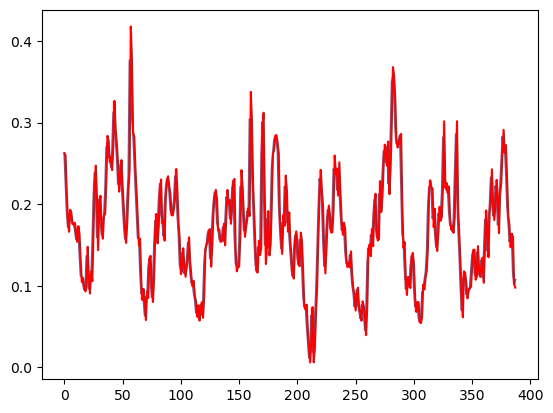

In [36]:
from sklearn.metrics import mean_squared_error
from math import sqrt

# split into train and test sets
X = df.values
size = int(len(X) * 0.66)
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]
predictions = list()
# walk-forward validation
for t in range(len(test)):
 model = ARIMA(history, order=(1,1,0))
 model_fit = model.fit()
 output = model_fit.forecast()
 yhat = output[0]
 predictions.append(yhat)
 obs = test[t]
 history.append(obs)
 print('predicted=%f, expected=%f' % (yhat, obs))
# evaluate forecasts
rmse = sqrt(mean_squared_error(test, predictions))
print('Test RMSE: %.3f' % rmse)
# plot forecasts against actual outcomes
plt.plot(test)
plt.plot(predictions, color='red')
plt.show()